In [1]:
#def process_gcn(payload, root):
#    if root.attrib['role'] != 'observation':
#        return

    # Read all of the VOEvent parameters from the "What" section.
#    params = {elem.attrib['name']:
#              elem.attrib['value']
#              for elem in root.iterfind('.//Param')}

#put into script to allow autorun

In [2]:
from astropy.io import fits
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value, FlatLambdaCDM
import urllib
import healpy as hp
from astropy.coordinates import SkyCoord

#import gcn

In [48]:
import time
start_time = time.time()
url='http://skyserver.sdss.org/dr15/en/tools/search/x_results.aspx?searchtool=SQL&'
file = 'bayestar14.fits.gz'

In [49]:
prob, distmu, distsigma, distnorm = hp.read_map(file, field = [0,1,2,3])
#hpy = hp.read_map('../bayestar.fits.gz')

NSIDE = 128
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING


In [50]:
hdul = fits.open(file)
t = hdul[1].header['OBJECT']
t

'G348901'

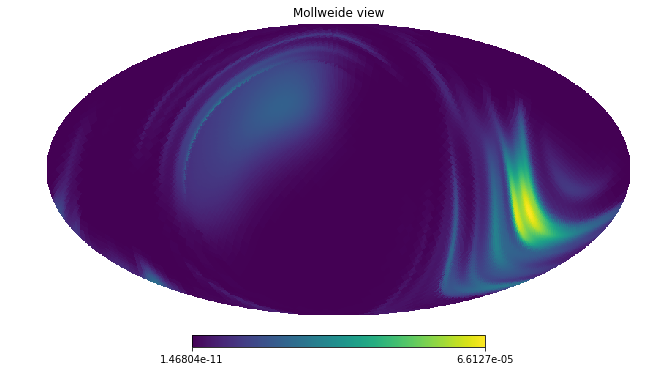

In [51]:
hp.mollview(prob, rot=180)
plt.savefig(t + '.png')

In [52]:
prob1 = list(prob)
npix = len(prob)
nside = hp.npix2nside(npix)

In [53]:
ipix = prob1.index(np.amax(prob1))
theta, phi = hp.pix2ang(nside, ipix)
ra = np.rad2deg(phi)
dec = np.rad2deg(0.5 * np.pi - theta)
ra, dec

(57.30468749999999, -21.381942579838896)

In [54]:
r = np.linspace(0,7000,num=1000)

In [55]:
def distance(rr, pixel):
    return distnorm[pixel]/(np.sqrt(2*np.pi)*distsigma[pixel])*np.exp(-(rr-distmu[pixel])**2 
                                                               /(2*distsigma[pixel])**2)*rr**2

Find the most probable distance of each pixel and the ra and dec for that pixel

In [56]:
most_probable_distance = []
ra, dec, std = [], [], []
probability = []

for pix1 in range(int(len(prob1))):
    if prob[pix1] < 1e-15:
        continue
    dist = distance(r,pix1)
    dist = list(dist)
    inde = dist.index(np.amax(dist))
    most_probable_distance.append(inde * 7) #in units of Mpc
    theta, phi = hp.pix2ang(nside, pix1)
    ra.append(np.rad2deg(phi))
    dec.append(np.rad2deg(0.5 * np.pi - theta))
    probability.append(prob1[pix1])

Append all data needed for an sql to a list and sort it so highest probability is at the top

In [97]:
# data1 is the same as data with duplicates removed
data,data1, z, stdz  = [], [], [], []
for i in range(int(len(probability))):
    if dec[i] > -10:
        data.append([probability[i] ,most_probable_distance[i],int(ra[i]), int(dec[i]), distsigma[i]])
    
data = sorted(data, key=lambda data: data[0]) #sort all data by the probability of the object
# being found in the ra and dec defined by that pixel

for i in range(int(len(data))):
    if data[i][3]!=data[i-1][3] and data[i][2]!=data[i-1][2]:
        coor = SkyCoord(ra = int(ra[i])*u.degree, dec = int(dec[i])*u.degree, frame='icrs')
        coorg = coor.galactic
        if coorg.b.degree > 20 or coorg.b.degree <(-20): #removes any ssignificant data hidden by galaxy
            data1.append([probability[i] ,most_probable_distance[i],int(ra[i]), int(dec[i]), distsigma[i]])


#for i in range(len(data1)):
for i in range(400):
    if data1[i][1] > 0.001:
        z.append(z_at_value(Planck13.luminosity_distance,data1[i][1]*u.Mpc)) #calculate the redshift
        stdz.append(z_at_value(Planck13.luminosity_distance,data1[i][4]*u.Mpc ) )

#print("--- %s seconds ---" % (time.time() - start_time))

Excludes data that is unobservable to us

In [98]:

data_for_telescope = []
for i in range(len(z)):
    sql = 'SELECT objid,ra,dec, class, z as redshift FROM SpecPhoto WHERE z >' + str(z[i] - 5* stdz[i]) + ' AND z < ' + str(z[i] + 5* stdz[i]) + ' AND class = "GALAXY" AND ra > ' + str(data[i][2] - 1) + ' AND ra < ' + str(data[i][2] + 1) + ' AND dec > '+ str(data[i][3] - 1) + ' AND dec <' + str(data[i][3] + 1)
    #performs sql for most probable sky locations
    params = urllib.parse.urlencode({'cmd': sql, 'format': 'fits'}) #open the connection and run the sql
    urllib.request.urlretrieve(url+params, 'gt1.fits'); #collect and save the data
    hud = fits.open('gt1.fits') # read the file the data was output to
    if len(hud) == 1:
        continue
    else:
        galaxies = (np.array(hud[1].data))
        for j in range(len(galaxies)):
            theta = 0.5 * np.pi - np.deg2rad(galaxies[j][2])
            phi = np.deg2rad(galaxies[j][1])
            pix = hp.ang2pix(nside, theta, phi)
            d = Planck13.luminosity_distance(galaxies[j][4])
            prob_of_gal = distance((d.value), pix)
            data_for_telescope.append([galaxies[j][0], galaxies[j][1], galaxies[j][2], galaxies[j][4]
                                           , d.value, prob_of_gal])


print("--- %s seconds ---" % (time.time() - start_time))

--- 9119.824975013733 seconds ---


In [99]:
data_for_telescope = sorted(data_for_telescope, key=lambda l: sum(l))
data_tele = []
ID = []
for i in range(len(data_for_telescope)):
    ID.append(data_for_telescope[i][0])
for i in range(len(data_for_telescope)):
    if ID[i] not in ID[0:i-1] and ID[i] not in ID[i+1:len(ID)-1]:
        data_tele.append(data_for_telescope[i])
data_tele = sorted(data_tele, key=lambda data_tele: data_tele[5], reverse=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 9180.51123547554 seconds ---


In [105]:
exp_time = []
for i in range(len(data_tele)):
    M_object = -15.8
    mag_source = M_object + 25 + np.log10(Planck13.luminosity_distance(data_tele[0][4]).value)
    M = 7.67
    x = (mag_source - M) / 2.5
    exp_time.append(1.6*10**x)

## Need to do: 
#####    1) Data visible during current date


In [107]:
import pandas as pd
Telescope = pd.DataFrame(data_tele)
Telescope.columns=['ID  ', '  RA  ', '  Dec  ', '  Redshift  ', '  Distance (MPC)  ', '  Probability  ']
Telescope['Exposure Time'] = exp_time

In [95]:
Telescope.to_csv(t, sep=' ')

In [117]:
%timeit prob_of_gal = distance((d.value), pix)

6.2 µs ± 48.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
coor = SkyCoord(ra = int(ra[1])*u.degree, dec = int(dec[1])*u.degree, frame='icrs')
coorg = coor.galactic
if coorg.b.degree > 20:
    print('b')

In [ ]:
np.mean(most_probable_distance)

In [ ]:
M_object = -15.8
mag_source = M_object + 25 + np.log10(Planck13.luminosity_distance(data_tele[0][4])/(1*u.Mpc))
M = 7.67
x = (mag_source - M) / 2.5
exp_time = 1.6*10**x

In [109]:
np.max(exp_time)/3600

0.9976012918511113

In [112]:
np.mean(Telescope['  Distance (MPC)  '])

453.7308808709609

In [71]:
most_probable_distance[1]

245